In [8]:
import itertools
import pulp
import matplotlib.pyplot as plt
from numpy import random
import numpy as np
rng = random.default_rng(42)  # For reproducibility

In [ ]:
#simulated data beed to replace with generalized dirichlet samples
profit1 = rng.integers(50,100,20)
profit2 = rng.integers(50,100,20)
weight = rng.integers(1,50,20)
capacity = 250
N = len(profit1)

In [10]:
# single-objective reference points
# 1. Maximize profit 1
model_p1 = pulp.LpProblem("max_profit1", pulp.LpMaximize)
x_p1 = pulp.LpVariable.dicts("x", range(N), cat="Binary")
model_p1 += pulp.lpSum(profit1[i]*x_p1[i] for i in range(N))
model_p1 += pulp.lpSum(weight[i]*x_p1[i] for i in range(N)) <= capacity
model_p1.solve(pulp.PULP_CBC_CMD(msg=0))
max_p1 = pulp.value(model_p1.objective)
choices_p1 = [i for i in range(N) if x_p1[i].value() > 0.5]
# 2. Maximize profit2
model_p2 = pulp.LpProblem("max_profit2", pulp.LpMaximize)
x_p2 = pulp.LpVariable.dicts("x", range(N), cat="Binary")
model_p2 += pulp.lpSum(profit2[i]*x_p2[i] for i in range(N))
model_p2 += pulp.lpSum(weight[i]*x_p2[i] for i in range(N)) <= capacity
model_p2.solve(pulp.PULP_CBC_CMD(msg=0))
max_p2 = pulp.value(model_p2.objective)

In [11]:

# ε-constraint baselibe.  for any value of profit 2 maxinimize profit 1
p1_val = []
p2_val = []
solutions = []

eps = 0
model = pulp.LpProblem(f"eps_{eps:.1f}", pulp.LpMaximize)
x = pulp.LpVariable.dicts("x", range(N), cat="Binary")
model += pulp.lpSum(profit1[i]*x[i] for i in range(N))
model += pulp.lpSum(profit2[i]*x[i] for i in range(N)) >= eps
model += pulp.lpSum(weight[i]*x[i] for i in range(N)) <= capacity
model.solve(pulp.PULP_CBC_CMD(msg=0))
if model.status == 1:  # optimal
    p1_val.append(pulp.value(model.objective))
    p2_val.append(sum(profit2[i]*x[i].value() for i in range(N)))
    choices = [i for i in range(N) if x[i].value() > 0.5]
    solutions.append(choices)

In [12]:
num_steps = 100

# ε-constraint loop: for different ε thresholds on profit2, maximize profit1

for eps in [max_p2 * i / num_steps for i in range(1, num_steps + 1)]:
    model = pulp.LpProblem(f"eps_{eps:.1f}", pulp.LpMaximize)
    x = pulp.LpVariable.dicts("x", range(N), cat="Binary")
    model += pulp.lpSum(profit1[i]*x[i] for i in range(N))
    model += pulp.lpSum(profit2[i]*x[i] for i in range(N)) >= eps
    model += pulp.lpSum(weight[i]*x[i] for i in range(N)) <= capacity
    model.solve(pulp.PULP_CBC_CMD(msg=0))
    if model.status == 1:  # optimal
        p1_val.append(pulp.value(model.objective))
        p2_val.append(sum(profit2[i]*x[i].value() for i in range(N)))
        choices = [i for i in range(N) if x[i].value() > 0.5]
        solutions.append(choices)



In [13]:
solutions = np.array(solutions);
unique_solutions, indices = np.unique(solutions, axis=0, return_index=True)
p1_val = np.array(p1_val)[indices]
p2_val = np.array(p2_val)[indices]

Found 4 Pareto solutions:

 0: Profit1 = 950.0, Profit2 = 1013.0, Items = [ 0  1  2  3  4  6 11 12 13 14 15 17 18]
 1: Profit1 = 1011.0, Profit2 = 999.0, Items = [ 0  1  3  4  6  7 11 12 13 14 15 16 17]
 2: Profit1 = 983.0, Profit2 = 1006.0, Items = [ 0  1  3  4  6 11 12 13 14 15 16 17 18]
 3: Profit1 = 1024.0, Profit2 = 983.0, Items = [ 0  3  4  6  7 11 12 13 14 15 16 17 19]


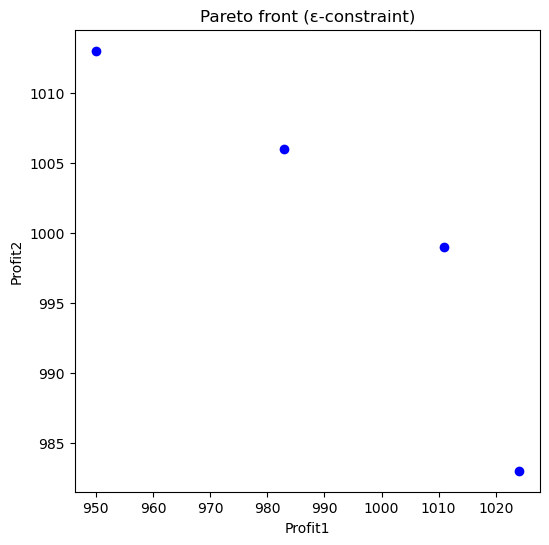

In [14]:

# Display results
print(f"Found {len(unique_solutions)} Pareto solutions:\n")
for idx,choices in enumerate(unique_solutions):
    print(f"{idx:2d}: Profit1 = {p1_val[idx]:.1f}, Profit2 = {p2_val[idx]:.1f}, Items = {choices}")

# Plot objective space
plt.figure(figsize=(6,6))
plt.scatter(p1_val, p2_val, c='blue', marker='o', label='Pareto front')
plt.xlabel("Profit1")
plt.ylabel("Profit2")
plt.title("Pareto front (ε‑constraint)")
plt.show()
